In [7]:
# Importaciones completas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LassoCV
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

In [8]:
# Obtener el directorio actual de trabajo (el directorio donde está el script)
current_directory = os.getcwd()

# Crear la ruta relativa a 'Modelo/df_modelo_limpio.csv' desde 'Pruebas_Modelo'
file_path = os.path.join(current_directory, '..', 'Modelo', 'df_modelo_limpio.csv')

# Verificar si la ruta es correcta
# print(file_path)

# Leer el archivo CSV
df_modelo = pd.read_csv(file_path)

# Mostrar las primeras filas del DataFrame
df_modelo.head()

,make,model,version,fuel,year,kms,power,shift,price,dealer_name,...,vehicle_age,price_per_power,price_per_year,dealer_info,power_per_kms,make_popularity,model_popularity,big_city_dealer,price_range,normalized_version
0,Opel,Crossland,1.2 GAS 110 GS Line 5p S/S,Gasolina,2022,5.0,110.0,manual,22900,Sergio Y.,...,3,208.19,7633.34,"Sergio Y.\r\n2, Carrer de Jacint Benavente, Po...",22.000000,4591,158,0,20-30k,12 gasolina 110 gs 2022
1,Opel,Crossland,1.2 81kW GS Line,Gasolina,2022,24847.0,110.0,manual,19990,Peugeot Alcala 534,...,3,181.73,6663.34,"Peugeot Alcala 534\r\nAvenida de José Gárate, ...",0.004427,4591,158,0,10-20k,12gs 2022
2,Opel,Crossland,1.5D 88kW Business Elegance Auto,Diésel,2021,41356.0,120.0,automatic,18590,Clicars S.,...,4,154.92,4647.50,"Clicars S.\r\nSan Cristóbal, Avenida de Andalu...",0.002902,4591,158,1,10-20k,15dbusiness elegance 2021
3,Opel,Crossland,GS-Line 1.2 GAS MT6 S/S,Gasolina,2022,11.0,110.0,manual,22700,Vallescar S.,...,3,206.37,7566.67,"Vallescar S.\r\nParc de Bombers de Sabadell, 5...",10.000000,4591,158,0,20-30k,12 gasolina 2022
4,Opel,Crossland,1.2 GS LINE 5P,Gasolina,2021,51390.0,110.0,manual,18200,onecar.es A.,...,4,165.46,4550.00,"onecar.es A.\r\nCalle de las Bulerías, Cruz de...",0.002140,4591,158,0,10-20k,12 gs line5p 2021


In [9]:
# Eliminar las filas con valores nulos en 'version' directamente en el DataFrame original
df_modelo.dropna(subset=['version'], inplace=True)

# Verificar que la fila ha sido eliminada
print(df_modelo.head())

   make      model                           version      fuel  year      kms  \
0  Opel  Crossland        1.2 GAS 110 GS Line 5p S/S  Gasolina  2022      5.0   
1  Opel  Crossland                  1.2 81kW GS Line  Gasolina  2022  24847.0   
2  Opel  Crossland  1.5D 88kW Business Elegance Auto    Diésel  2021  41356.0   
3  Opel  Crossland           GS-Line 1.2 GAS MT6 S/S  Gasolina  2022     11.0   
4  Opel  Crossland                    1.2 GS LINE 5P  Gasolina  2021  51390.0   

   power      shift  price         dealer_name  ... vehicle_age  \
0  110.0     manual  22900           Sergio Y.  ...           3   
1  110.0     manual  19990  Peugeot Alcala 534  ...           3   
2  120.0  automatic  18590          Clicars S.  ...           4   
3  110.0     manual  22700        Vallescar S.  ...           3   
4  110.0     manual  18200        onecar.es A.  ...           4   

  price_per_power  price_per_year  \
0          208.19         7633.34   
1          181.73         6663.34   

In [10]:
# 4. FEATURE ENGINEERING
print("\n" + "=" *50)
print("FEATURE ENGINEERING")
print("=" *50)


FEATURE ENGINEERING


In [11]:
# Selección de características base
features = ['year', 'kms', 'power', 'vehicle_age', 'fuel', 'shift', 'make', 'model']
target = 'price'


In [12]:
# Crear copia para no modificar el dataframe original
df_engineered = df_modelo.copy()

In [13]:
# Nuevas características basadas en ratios
print("Creando nuevas características...")
df_engineered['power_to_age'] = df_engineered['power'] / (df_engineered['vehicle_age'] + 1)  # +1 para evitar división por cero
df_engineered['kms_per_year'] = df_engineered['kms'] / (df_engineered['vehicle_age'] + 1)

Creando nuevas características...


In [14]:
# Características logarítmicas para variables numéricas
for col in ['kms', 'power', 'vehicle_age']:
    df_engineered[f'log_{col}'] = np.log1p(df_engineered[col])

In [15]:
# Las características polinómicas las crearemos dentro del pipeline
# en lugar de añadirlas directamente al DataFrame
print(f"Número original de características: {len(features)}")
print(f"Número de características después de feature engineering: {df_engineered.shape[1] - 1}")

Número original de características: 8
Número de características después de feature engineering: 28


In [16]:
# Definir las características a utilizar para el modelado
# Excluimos el target 'price' y columnas que no se usarán
all_features = [col for col in df_engineered.columns if col != target and col not in ['id', 'date']]

In [17]:
# Verificar si hay nombres de columnas duplicados
duplicate_columns = df_engineered.columns[df_engineered.columns.duplicated()].tolist()
print(f"Columnas duplicadas encontradas: {duplicate_columns}")


Columnas duplicadas encontradas: []


In [18]:
# Separar en características categóricas y numéricas
categorical_features = [col for col in all_features if pd.api.types.is_object_dtype(df_engineered[col])]
numeric_features = [col for col in all_features if col not in categorical_features]

In [19]:
# Seleccionar un subconjunto de características numéricas para la transformación polinómica
# Usamos solo características básicas para evitar una explosión dimensional
poly_features = ['year', 'kms', 'power', 'vehicle_age']

In [20]:
# Las características que no se transformarán polinómicamente
remaining_numeric = [col for col in numeric_features if col not in poly_features]


In [21]:
print(f"Características numéricas para transformación polinómica: {poly_features}")
print(f"Otras características numéricas: {remaining_numeric[:5]}... (truncado)")
print(f"Características categóricas: {categorical_features}")

Características numéricas para transformación polinómica: ['year', 'kms', 'power', 'vehicle_age']
Otras características numéricas: ['dealer_zip_code', 'price_per_power', 'price_per_year', 'power_per_kms', 'make_popularity']... (truncado)
Características categóricas: ['make', 'model', 'version', 'fuel', 'shift', 'dealer_name', 'dealer_address', 'dealer_city', 'province', 'dealer_info', 'price_range', 'normalized_version']


In [22]:
# 5. MANEJO DE OUTLIERS
print("\n" + "="*50)
print("MANEJO DE OUTLIERS")
print("="*50)


MANEJO DE OUTLIERS


In [23]:
# Calcular los cuartiles y el IQR para la variable objetivo
Q1 = df_engineered['price'].quantile(0.25)
Q3 = df_engineered['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Límite inferior para outliers: {lower_bound}")
print(f"Límite superior para outliers: {upper_bound}")
print(f"Número de outliers por debajo del límite: {(df_engineered['price'] < lower_bound).sum()}")
print(f"Número de outliers por encima del límite: {(df_engineered['price'] > upper_bound).sum()}")

Límite inferior para outliers: -11363.75
Límite superior para outliers: 41858.25
Número de outliers por debajo del límite: 0
Número de outliers por encima del límite: 171


In [24]:
# Crear versión con outliers recortados
df_no_outliers = df_engineered[(df_engineered['price'] >= lower_bound) & (df_engineered['price'] <= upper_bound)]
print(f"Tamaño del dataframe original: {df_engineered.shape[0]}")
print(f"Tamaño del dataframe sin outliers: {df_no_outliers.shape[0]}")
print(f"Porcentaje de datos retenidos: {df_no_outliers.shape[0]/df_engineered.shape[0]*100:.2f}%")

Tamaño del dataframe original: 8915
Tamaño del dataframe sin outliers: 8744
Porcentaje de datos retenidos: 98.08%


In [25]:
# 6. PREPARACIÓN DE DATOS
print("\n" + "="*50)
print("PREPARACIÓN DE DATOS")
print("="*50)


PREPARACIÓN DE DATOS


In [26]:
# División del conjunto de datos - usaremos ambas versiones (con y sin outliers)
# Primero con el conjunto completo
# División del conjunto de datos
X_full = df_engineered[all_features]
y_full = df_engineered[target]
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, y_full, test_size=0.2, random_state=42)


In [27]:
# Luego con el conjunto sin outliers
X_clean = df_no_outliers[all_features]
y_clean = df_no_outliers[target]
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

print(f"Conjunto de entrenamiento completo: {X_train_full.shape[0]} muestras")
print(f"Conjunto de test completo: {X_test_full.shape[0]} muestras")
print(f"Conjunto de entrenamiento sin outliers: {X_train_clean.shape[0]} muestras")
print(f"Conjunto de test sin outliers: {X_test_clean.shape[0]} muestras")


Conjunto de entrenamiento completo: 7132 muestras
Conjunto de test completo: 1783 muestras
Conjunto de entrenamiento sin outliers: 6995 muestras
Conjunto de test sin outliers: 1749 muestras


In [28]:
# 7. CREACIÓN DE PIPELINES PARA DIFERENTES TIPOS DE MODELOS
print("\n" + "="*50)
print("CREACIÓN DE PIPELINES ESPECÍFICOS")
print("="*50)


CREACIÓN DE PIPELINES ESPECÍFICOS


In [29]:
# Transformador para características numéricas estándar
numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])

# Transformador para características polinómicas
poly_transformer = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler())
])

# Transformador para características categóricas
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Preprocesador para modelos no basados en árboles (con escalado)
non_tree_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, remaining_numeric),
        ('poly', poly_transformer, poly_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'  # Descartar cualquier columna no especificada
)

In [30]:
# Preprocesador para modelos basados en árboles (sin escalado de características numéricas)
tree_preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

print("Preprocesadores creados:")
print("- non_tree_preprocessor: Para modelos como KNN, Ridge, Lasso, etc.")
print("- tree_preprocessor: Para modelos como RandomForest, XGBoost, LightGBM, etc.")

Preprocesadores creados:
- non_tree_preprocessor: Para modelos como KNN, Ridge, Lasso, etc.
- tree_preprocessor: Para modelos como RandomForest, XGBoost, LightGBM, etc.


In [31]:
# 8. TRANSFORMACIÓN DEL TARGET (OPCIONAL)
print("\n" + "="*50)
print("TRANSFORMACIÓN DEL TARGET (LOGARÍTMICA)")
print("="*50)


TRANSFORMACIÓN DEL TARGET (LOGARÍTMICA)


In [32]:
# Crear versiones logarítmicas del target para probar
y_train_log = np.log1p(y_train_full)
y_test_log = np.log1p(y_test_full)

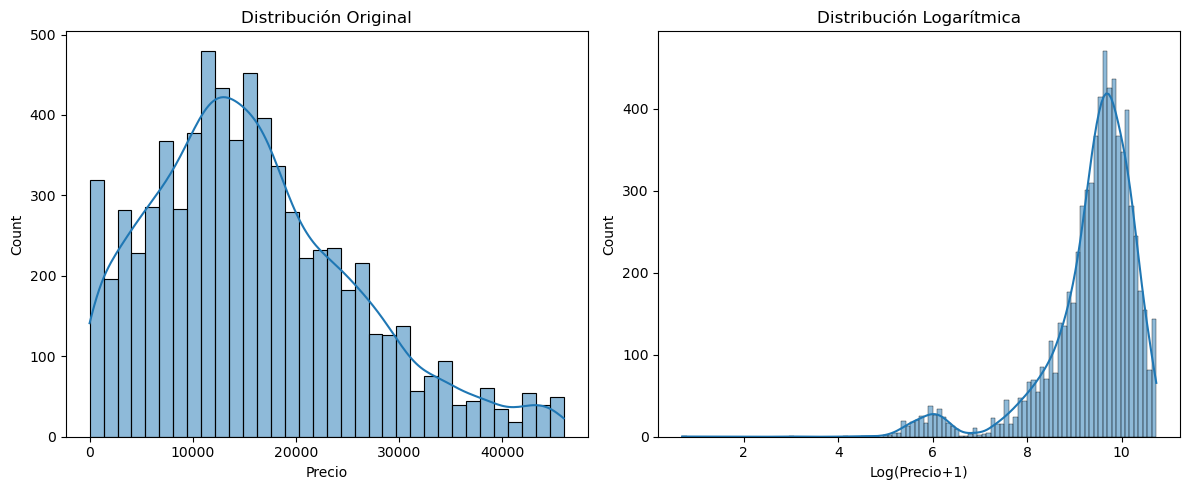

Se han creado versiones logarítmicas del target para evaluar si mejora el rendimiento.


In [33]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(y_train_full, kde=True)
plt.title('Distribución Original')
plt.xlabel('Precio')

plt.subplot(1, 2, 2)
sns.histplot(y_train_log, kde=True)
plt.title('Distribución Logarítmica')
plt.xlabel('Log(Precio+1)')

plt.tight_layout()
plt.show()

print("Se han creado versiones logarítmicas del target para evaluar si mejora el rendimiento.")

In [34]:
# 9. EVALUACIÓN DEL MODELO BASE (KNN)
print("\n" + "="*50)
print("EVALUACIÓN DEL MODELO BASE (KNN)")
print("="*50)


EVALUACIÓN DEL MODELO BASE (KNN)


In [35]:
# Crear pipeline para KNN
knn_pipeline = Pipeline([
    ('preprocessor', non_tree_preprocessor),
    ('model', KNeighborsRegressor())
])

# Búsqueda de hiperparámetros para KNN
param_grid_knn = {
    'model__n_neighbors': [3, 5, 7, 9, 11, 15],
    'model__weights': ['uniform', 'distance'],
    'model__p': [1, 2]  # p=1 (Manhattan) o p=2 (Euclidiana)
}

# Grid search con validación cruzada
grid_search_knn = GridSearchCV(
    knn_pipeline, 
    param_grid_knn, 
    cv=5, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1,
    verbose=1  # Aumentamos la verbosidad para ver el progreso
)


In [73]:
grid_search_knn.fit(X_train_clean, y_train_clean)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['dealer_zip_code',
                                                                          'price_per_power',
                                                                          'price_per_year',
                                                                          'power_per_kms',
                                                                          'make_popularity',
                                                                          'model_popularity',
                                                                          'big_city_dealer',
                                                                          'power_to_age',
                                                                          'kms_per_year',
                                                                          'log_kms',
                                                                          'log_power',
                                                                          'log_vehicle_age']),
                                                                        ('poly',...
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['make',
                                                                          'model',
                                                                          'version',
                                                                          'fuel',
                                                                          'shift',
                                                                          'dealer_name',
                                                                          'dealer_address',
                                                                          'dealer_city',
                                                                          'province',
                                                                          'dealer_info',
                                                                          'price_range',
                                                                          'normalized_version'])])),
                                       ('model', KNeighborsRegressor())]),
             n_jobs=-1,
             param_grid={'model__n_neighbors': [3, 5, 7, 9, 11, 15],
                         'model__p': [1, 2],
                         'model__weights': ['uniform', 'distance']},
             scoring='neg_mean_squared_error', verbose=1)

In [74]:
# Obtener mejores parámetros y puntuación
best_params_knn = grid_search_knn.best_params_
best_score_knn = np.sqrt(-grid_search_knn.best_score_)  # Convertimos a RMSE
    
print(f"Mejores parámetros para KNN: {best_params_knn}")
print(f"Mejor RMSE en validación cruzada: {best_score_knn:.2f}")

Mejores parámetros para KNN: {'model__n_neighbors': 7, 'model__p': 1, 'model__weights': 'distance'}
Mejor RMSE en validación cruzada: 2658.81


In [75]:
knn_best = grid_search_knn.best_estimator_
y_pred_knn = knn_best.predict(X_test_clean)

In [76]:
# Evaluación en conjunto de prueba
rmse_knn = np.sqrt(mean_squared_error(y_test_clean, y_pred_knn))
mae_knn = mean_absolute_error(y_test_clean, y_pred_knn)
mape_knn = mean_absolute_percentage_error(y_test_clean, y_pred_knn)
r2_knn = r2_score(y_test_clean, y_pred_knn)


print(f"Mejores parámetros para KNN: {grid_search_knn.best_params_}")
print(f"RMSE: {rmse_knn:.2f} €")
print(f"MAE: {mae_knn:.2f} €")
print(f"MAPE: {mape_knn*100:.2f}%")
print(f"R²: {r2_knn:.4f}")


Mejores parámetros para KNN: {'model__n_neighbors': 7, 'model__p': 1, 'model__weights': 'distance'}
RMSE: 2658.89 €
MAE: 1748.38 €
MAPE: 31.67%
R²: 0.9130


In [37]:
# 10. EVALUACIÓN DE RANDOM FOREST
print("\n" + "="*50)
print("EVALUACIÓN DE RANDOM FOREST")
print("="*50)


EVALUACIÓN DE RANDOM FOREST


In [38]:
# Crear pipeline para Random Forest
rf_pipeline = Pipeline([
    ('preprocessor', tree_preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

# Parámetros para Random Forest
param_grid_rf = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 20, 30],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2]
}

# Grid search para Random Forest
grid_search_rf = GridSearchCV(
    rf_pipeline, 
    param_grid_rf, 
    cv=5, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1,
    verbose=0
)


In [39]:
print("Ejecutando Grid Search para Random Forest...")
grid_search_rf.fit(X_train_clean, y_train_clean)


Ejecutando Grid Search para Random Forest...


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         'passthrough',
                                                                         ['year',
                                                                          'kms',
                                                                          'power',
                                                                          'dealer_zip_code',
                                                                          'vehicle_age',
                                                                          'price_per_power',
                                                                          'price_per_year',
                                                                          'power_per_kms',
                                                                          'make_popularity',
                                                                          'model_popularity',
                                                                          'big_city_dealer',
                                                                          'power_to_age',
                                                                          'kms_per_year',
                                                                          'log_kms',
                                                                          'log_power',
                                                                          'log_vehicle_age']),
                                                                        ('cat...
                                                                          'shift',
                                                                          'dealer_name',
                                                                          'dealer_address',
                                                                          'dealer_city',
                                                                          'province',
                                                                          'dealer_info',
                                                                          'price_range',
                                                                          'normalized_version'])])),
                                       ('model',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [None, 20, 30],
                         'model__min_samples_leaf': [1, 2],
                         'model__min_samples_split': [2, 5],
                         'model__n_estimators': [100, 200]},
             scoring='neg_mean_squared_error')

In [40]:
# Mejor modelo RF
best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test_clean)

In [41]:
# Evaluar el modelo RF
rmse_rf = np.sqrt(mean_squared_error(y_test_clean, y_pred_rf))
mae_rf = mean_absolute_error(y_test_clean, y_pred_rf)
mape_rf = mean_absolute_percentage_error(y_test_clean, y_pred_rf)
r2_rf = r2_score(y_test_clean, y_pred_rf)

print(f"Mejores parámetros para Random Forest: {grid_search_rf.best_params_}")
print(f"RMSE: {rmse_rf:.2f} €")
print(f"MAE: {mae_rf:.2f} €")
print(f"MAPE: {mape_rf*100:.2f}%")
print(f"R²: {r2_rf:.4f}")

Mejores parámetros para Random Forest: {'model__max_depth': None, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 200}
RMSE: 527.26 €
MAE: 230.63 €
MAPE: 1.75%
R²: 0.9966


In [42]:
# 11. EVALUACIÓN DE XGBOOST
print("\n" + "="*50)
print("EVALUACIÓN DE XGBOOST")
print("="*50)


EVALUACIÓN DE XGBOOST


In [43]:
# Crear pipeline para XGBoost
xgb_pipeline = Pipeline([
    ('preprocessor', tree_preprocessor),
    ('model', XGBRegressor(
        objective='reg:squarederror',
        random_state=42
    ))
])

# Parámetros para XGBoost
param_grid_xgb = {
    'model__n_estimators': [100, 200],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [3, 6, 9],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0]
}

# Grid search para XGBoost
grid_search_xgb = GridSearchCV(
    xgb_pipeline, 
    param_grid_xgb, 
    cv=5, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1,
    verbose=0
)

In [44]:
print("Ejecutando Grid Search para XGBoost...")
grid_search_xgb.fit(X_train_clean, y_train_clean)

Ejecutando Grid Search para XGBoost...


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         'passthrough',
                                                                         ['year',
                                                                          'kms',
                                                                          'power',
                                                                          'dealer_zip_code',
                                                                          'vehicle_age',
                                                                          'price_per_power',
                                                                          'price_per_year',
                                                                          'power_per_kms',
                                                                          'make_popularity',
                                                                          'model_popularity',
                                                                          'big_city_dealer',
                                                                          'power_to_age',
                                                                          'kms_per_year',
                                                                          'log_kms',
                                                                          'log_power',
                                                                          'log_vehicle_age']),
                                                                        ('cat...
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'model__colsample_bytree': [0.8, 1.0],
                         'model__learning_rate': [0.01, 0.05, 0.1],
                         'model__max_depth': [3, 6, 9],
                         'model__n_estimators': [100, 200],
                         'model__subsample': [0.8, 1.0]},
             scoring='neg_mean_squared_error')

In [47]:
# Mejor modelo XGBoost
best_xgb = grid_search_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test_clean)

In [48]:
# Evaluar el modelo XGBoost
rmse_xgb = np.sqrt(mean_squared_error(y_test_clean, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test_clean, y_pred_xgb)
mape_xgb = mean_absolute_percentage_error(y_test_clean, y_pred_xgb)
r2_xgb = r2_score(y_test_clean, y_pred_xgb)

print(f"Mejores parámetros para XGBoost: {grid_search_xgb.best_params_}")
print(f"RMSE: {rmse_xgb:.2f} €")
print(f"MAE: {mae_xgb:.2f} €")
print(f"MAPE: {mape_xgb*100:.2f}%")
print(f"R²: {r2_xgb:.4f}")

Mejores parámetros para XGBoost: {'model__colsample_bytree': 1.0, 'model__learning_rate': 0.05, 'model__max_depth': 9, 'model__n_estimators': 200, 'model__subsample': 0.8}
RMSE: 434.76 €
MAE: 212.97 €
MAPE: 1.81%
R²: 0.9977


In [45]:
# 12. EVALUACIÓN DE LIGHTGBM
print("\n" + "="*50)
print("EVALUACIÓN DE LIGHTGBM")
print("="*50)


EVALUACIÓN DE LIGHTGBM


In [46]:
# Crear pipeline para LightGBM
lgbm_pipeline = Pipeline([
    ('preprocessor', tree_preprocessor),
    ('model', LGBMRegressor(random_state=42))
])

# Parámetros para LightGBM (reducidos para evitar tiempo excesivo)
param_grid_lgbm = {
    'model__n_estimators': [100, 200],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__num_leaves': [31, 50],
    'model__max_depth': [5, 9],
    'model__min_child_samples': [20, 30]
}

# Grid search para LightGBM
grid_search_lgbm = GridSearchCV(
    lgbm_pipeline, 
    param_grid_lgbm, 
    cv=5, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1,
    verbose=0
)

In [49]:
print("Ejecutando Grid Search para LightGBM...")
grid_search_lgbm.fit(X_train_clean, y_train_clean)

Ejecutando Grid Search para LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,002014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3435
[LightGBM] [Info] Number of data points in the train set: 6995, number of used features: 363
[LightGBM] [Info] Start training from score 15348,076769
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         'passthrough',
                                                                         ['year',
                                                                          'kms',
                                                                          'power',
                                                                          'dealer_zip_code',
                                                                          'vehicle_age',
                                                                          'price_per_power',
                                                                          'price_per_year',
                                                                          'power_per_kms',
                                                                          'make_popularity',
                                                                          'model_popularity',
                                                                          'big_city_dealer',
                                                                          'power_to_age',
                                                                          'kms_per_year',
                                                                          'log_kms',
                                                                          'log_power',
                                                                          'log_vehicle_age']),
                                                                        ('cat...
                                                                          'dealer_address',
                                                                          'dealer_city',
                                                                          'province',
                                                                          'dealer_info',
                                                                          'price_range',
                                                                          'normalized_version'])])),
                                       ('model',
                                        LGBMRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01, 0.05, 0.1],
                         'model__max_depth': [5, 9],
                         'model__min_child_samples': [20, 30],
                         'model__n_estimators': [100, 200],
                         'model__num_leaves': [31, 50]},
             scoring='neg_mean_squared_error')

In [50]:
# Mejor modelo LightGBM
best_lgbm = grid_search_lgbm.best_estimator_
y_pred_lgbm = best_lgbm.predict(X_test_clean)


In [51]:
# Evaluar el modelo LightGBM
rmse_lgbm = np.sqrt(mean_squared_error(y_test_clean, y_pred_lgbm))
mae_lgbm = mean_absolute_error(y_test_clean, y_pred_lgbm)
mape_lgbm = mean_absolute_percentage_error(y_test_clean, y_pred_lgbm)
r2_lgbm = r2_score(y_test_clean, y_pred_lgbm)

print(f"Mejores parámetros para LightGBM: {grid_search_lgbm.best_params_}")
print(f"RMSE: {rmse_lgbm:.2f} €")
print(f"MAE: {mae_lgbm:.2f} €")
print(f"MAPE: {mape_lgbm*100:.2f}%")
print(f"R²: {r2_lgbm:.4f}")

Mejores parámetros para LightGBM: {'model__learning_rate': 0.1, 'model__max_depth': 9, 'model__min_child_samples': 20, 'model__n_estimators': 200, 'model__num_leaves': 31}
RMSE: 459.98 €
MAE: 267.25 €
MAPE: 3.23%
R²: 0.9974


In [52]:
# 13. APRENDIZAJE CON TARGET TRANSFORMADO (LOGARÍTMICO)
print("\n" + "="*50)
print("MODELO CON TARGET LOGARÍTMICO")
print("="*50)


MODELO CON TARGET LOGARÍTMICO


In [53]:
lgbm_pipeline.fit(X_train_clean, np.log1p(y_train_clean))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,002342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3435
[LightGBM] [Info] Number of data points in the train set: 6995, number of used features: 363
[LightGBM] [Info] Start training from score 9,332430


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['year', 'kms', 'power',
                                                   'dealer_zip_code',
                                                   'vehicle_age',
                                                   'price_per_power',
                                                   'price_per_year',
                                                   'power_per_kms',
                                                   'make_popularity',
                                                   'model_popularity',
                                                   'big_city_dealer',
                                                   'power_to_age',
                                                   'kms_per_year', 'log_kms',
                                                   'log_power',
                                                   'log_vehicle_age']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['make', 'model', 'version',
                                                   'fuel', 'shift',
                                                   'dealer_name',
                                                   'dealer_address',
                                                   'dealer_city', 'province',
                                                   'dealer_info', 'price_range',
                                                   'normalized_version'])])),
                ('model', LGBMRegressor(random_state=42))])

In [116]:
# Entrenamos con el target logarítmico
#best_pipeline.fit(X_train_clean, np.log1p(y_train_clean))

In [54]:
# Predecimos y transformamos de vuelta
y_pred_log = lgbm_pipeline.predict(X_test_clean)
y_pred_exp = np.expm1(y_pred_log)


In [55]:
# Evaluar el modelo con target transformado
rmse_log = np.sqrt(mean_squared_error(y_test_clean, y_pred_exp))
mae_log = mean_absolute_error(y_test_clean, y_pred_exp)
mape_log = mean_absolute_percentage_error(y_test_clean, y_pred_exp)
r2_log = r2_score(y_test_clean, y_pred_exp)

print(f"Evaluación del modelo con target logarítmico:")
print(f"RMSE: {rmse_log:.2f} €")
print(f"MAE: {mae_log:.2f} €")
print(f"MAPE: {mape_log*100:.2f}%")
print(f"R²: {r2_log:.4f}")


Evaluación del modelo con target logarítmico:
RMSE: 603.98 €
MAE: 349.25 €
MAPE: 2.60%
R²: 0.9955


In [56]:
# 14. STACKING ENSEMBLE AVANZADO
print("\n" + "="*50)
print("STACKING ENSEMBLE AVANZADO")
print("="*50)



STACKING ENSEMBLE AVANZADO


In [57]:
print(grid_search_rf.best_params_)
print(grid_search_xgb.best_params_)
print(grid_search_lgbm.best_params_)

{'model__max_depth': None, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 200}
{'model__colsample_bytree': 1.0, 'model__learning_rate': 0.05, 'model__max_depth': 9, 'model__n_estimators': 200, 'model__subsample': 0.8}
{'model__learning_rate': 0.1, 'model__max_depth': 9, 'model__min_child_samples': 20, 'model__n_estimators': 200, 'model__num_leaves': 31}


In [58]:
# Función para limpiar los nombres de los hiperparámetros
def clean_params(params):
    return {key.replace('model__', ''): value for key, value in params.items()}

# Crear modelos base utilizando los mejores hiperparámetros ya encontrados
base_models = [
    ('rf', RandomForestRegressor(**clean_params(grid_search_rf.best_params_), random_state=42)),
    ('xgb', XGBRegressor(**clean_params(grid_search_xgb.best_params_), random_state=42)),
    ('lgbm', LGBMRegressor(**clean_params(grid_search_lgbm.best_params_), random_state=42))
]

# Meta-learners a probar
meta_learners = {
    'elastic': ElasticNet(random_state=42, alpha=0.1, l1_ratio=0.5),
    'lasso': Lasso(random_state=42, alpha=0.01),
    'ridge': Ridge(random_state=42, alpha=1.0),
    'xgb_meta': XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=3, random_state=42)
}

# Entrenar y evaluar cada combinación de stacking
results = {}

In [59]:
# Creamos preprocesadores para modelos base
preprocessed_X_train = tree_preprocessor.fit_transform(X_train_clean)
preprocessed_X_test = tree_preprocessor.transform(X_test_clean)

In [60]:
print("Evaluando diferentes configuraciones de stacking:")

for meta_name, meta_model in meta_learners.items():
    # Crear el ensamble de stacking
    stacking = StackingRegressor(
        estimators=base_models,
        final_estimator=meta_model,
        cv=5,
        n_jobs=-1
    )
    
    # Entrenar en datos preprocesados
    stacking.fit(preprocessed_X_train, y_train_clean)
    
    # Predecir
    y_pred_stack = stacking.predict(preprocessed_X_test)
    
    # Evaluar
    r2_stack = r2_score(y_test_clean, y_pred_stack)
    rmse_stack = np.sqrt(mean_squared_error(y_test_clean, y_pred_stack))
    
    results[meta_name] = (r2_stack, rmse_stack)
    print(f"Meta-learner: {meta_name}, R²: {r2_stack:.4f}, RMSE: {rmse_stack:.2f}")


Evaluando diferentes configuraciones de stacking:
Meta-learner: elastic, R²: 0.9979, RMSE: 409.91
Meta-learner: lasso, R²: 0.9979, RMSE: 409.91
Meta-learner: ridge, R²: 0.9980, RMSE: 401.07
Meta-learner: xgb_meta, R²: 0.9980, RMSE: 400.24


In [61]:
# Encontrar el mejor meta-learner
best_meta = max(results.items(), key=lambda x: x[1][0])
print(f"\nMejor meta-learner: {best_meta[0]} con R²: {best_meta[1][0]:.4f}, RMSE: {best_meta[1][1]:.2f}")



Mejor meta-learner: xgb_meta con R²: 0.9980, RMSE: 400.24


In [62]:
# 15. ANÁLISIS DE IMPORTANCIA DE CARACTERÍSTICAS
print("\n" + "="*50)
print("ANÁLISIS DE IMPORTANCIA DE CARACTERÍSTICAS")
print("="*50)


ANÁLISIS DE IMPORTANCIA DE CARACTERÍSTICAS


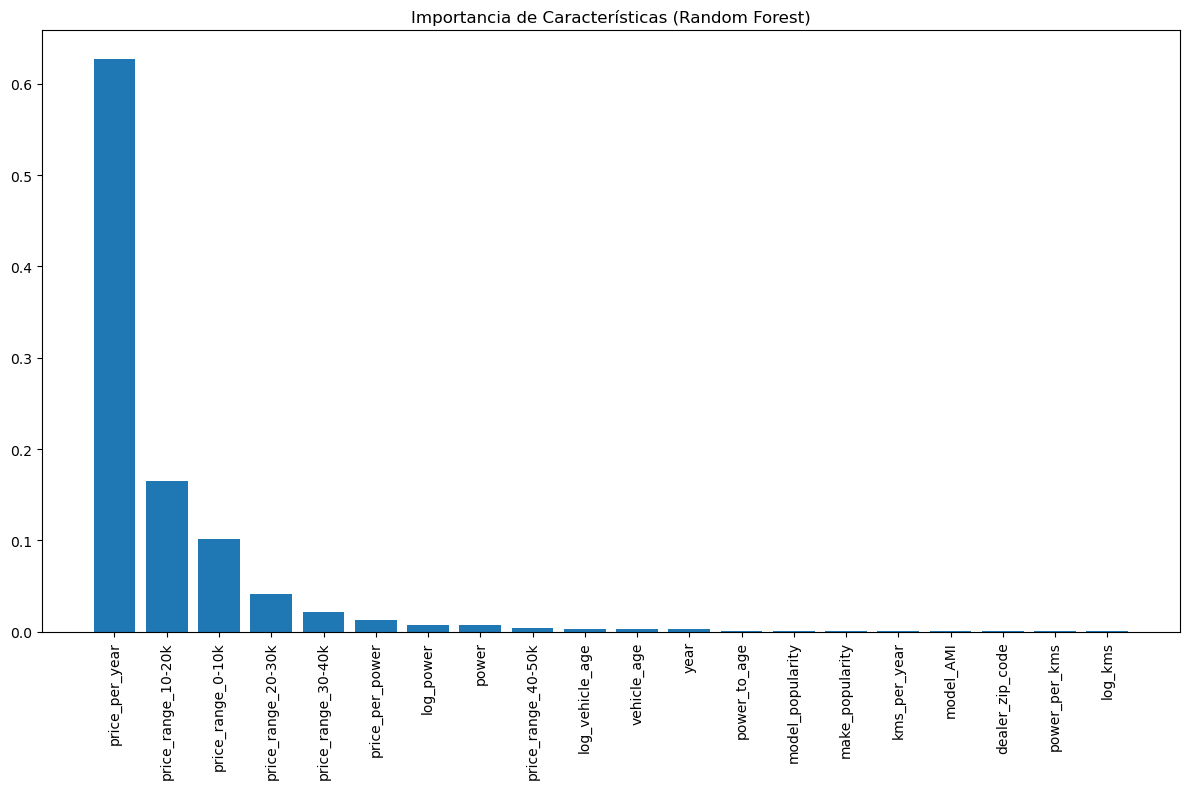

Top 10 características más importantes:
1. price_per_year (0.6271)
2. price_range_10-20k (0.1648)
3. price_range_0-10k (0.1010)
4. price_range_20-30k (0.0408)
5. price_range_30-40k (0.0212)
6. price_per_power (0.0132)
7. log_power (0.0076)
8. power (0.0073)
9. price_range_40-50k (0.0035)
10. log_vehicle_age (0.0031)

CURVAS DE APRENDIZAJE


In [63]:
# Utilizamos el modelo Random Forest para el análisis
rf_model = best_rf.named_steps['model']

# Obtener las características después del preprocesamiento
preprocessor = best_rf.named_steps['preprocessor']
feature_names = (
    numeric_features +
    list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
)

# Importancia de características
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Mostrar las características más importantes
plt.figure(figsize=(12, 8))
plt.title('Importancia de Características (Random Forest)')
plt.bar(range(min(20, len(feature_names))), 
        [importances[i] for i in indices[:20]], 
        align='center')
plt.xticks(range(min(20, len(feature_names))), 
           [feature_names[i] for i in indices[:20]], 
           rotation=90)
plt.tight_layout()
plt.show()

print("Top 10 características más importantes:")
for i in range(min(10, len(feature_names))):
    print(f"{i+1}. {feature_names[indices[i]]} ({importances[indices[i]]:.4f})")

# 16. CURVAS DE APRENDIZAJE
print("\n" + "="*50)
print("CURVAS DE APRENDIZAJE")
print("="*50)

In [64]:
# Usar el mejor modelo para las curvas de aprendizaje
best_model = best_rf  # Ajustar según resultados

# Calcular curvas de aprendizaje
train_sizes, train_scores, valid_scores = learning_curve(
    best_model, X_clean, y_clean, 
    train_sizes=np.linspace(0.1, 1.0, 10), 
    cv=5, 
    scoring='r2',
    n_jobs=-1
)

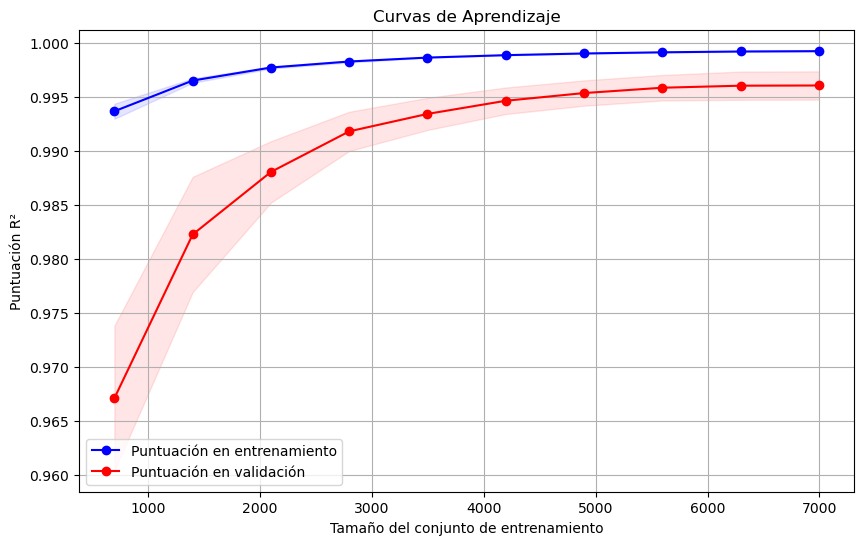

Las curvas de aprendizaje indican si el modelo podría beneficiarse de más datos o está sobreajustando.
Una brecha grande entre las curvas de entrenamiento y validación indica sobreajuste.
Curvas que no llegan a una meseta indican que más datos podrían mejorar el rendimiento.


In [132]:
# Calcular medias y desviaciones estándar
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

# Graficar las curvas de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Puntuación en entrenamiento')
plt.plot(train_sizes, valid_mean, 'o-', color='red', label='Puntuación en validación')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, valid_mean - valid_std, valid_mean + valid_std, alpha=0.1, color='red')
plt.title('Curvas de Aprendizaje')
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('Puntuación R²')
plt.legend()
plt.grid(True)
plt.show()

print("Las curvas de aprendizaje indican si el modelo podría beneficiarse de más datos o está sobreajustando.")
print("Una brecha grande entre las curvas de entrenamiento y validación indica sobreajuste.")
print("Curvas que no llegan a una meseta indican que más datos podrían mejorar el rendimiento.")


In [65]:
# 17. VALIDACIÓN CRUZADA PARA EL MEJOR MODELO
print("\n" + "="*50)
print("VALIDACIÓN CRUZADA PARA EL MEJOR MODELO")
print("="*50)


VALIDACIÓN CRUZADA PARA EL MEJOR MODELO


In [66]:
# Definir estrategia de validación cruzada
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluar el mejor modelo con validación cruzada
cv_scores = cross_val_score(
    best_model, 
    X_clean, 
    y_clean, 
    cv=cv, 
    scoring='r2', 
    n_jobs=-1
)

print(f"Puntuaciones de R² en validación cruzada: {cv_scores}")
print(f"R² medio: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


Puntuaciones de R² en validación cruzada: [0.9965436  0.99589403 0.99620115 0.99629595 0.99708798]
R² medio: 0.9964 ± 0.0004


In [67]:
# 18. COMPARACIÓN FINAL DE MODELOS
print("\n" + "="*50)
print("COMPARACIÓN FINAL DE MODELOS")
print("="*50)


COMPARACIÓN FINAL DE MODELOS


In [77]:
# Recopilar resultados de todos los modelos
model_results = {
    'KNN': (r2_knn, rmse_knn, mae_knn, mape_knn),
    'Random Forest': (r2_rf, rmse_rf, mae_rf, mape_rf),
    'XGBoost': (r2_xgb, rmse_xgb, mae_xgb, mape_xgb),
    'LightGBM': (r2_lgbm, rmse_lgbm, mae_lgbm, mape_lgbm),
    'Target Logarítmico': (r2_log, rmse_log, mae_log, mape_log),
    f'Stacking ({best_meta[0]})': (best_meta[1][0], best_meta[1][1], None, None)  # No calculamos MAE/MAPE para stacking
}

# Crear DataFrame con los resultados
results_df = pd.DataFrame(model_results).T
results_df.columns = ['R²', 'RMSE', 'MAE', 'MAPE']

# Ordenar por R²
results_df = results_df.sort_values('R²', ascending=False)

Comparación de modelos:
                           R²         RMSE          MAE      MAPE
Stacking (xgb_meta)  0.998029   400.240501          NaN       NaN
XGBoost              0.997674   434.756418   212.969264  0.018124
LightGBM             0.997396   459.976904   267.252169  0.032315
Random Forest        0.996579   527.255010   230.629287  0.017499
Target Logarítmico   0.995511   603.976192   349.247767  0.026002
KNN                  0.913003  2658.885828  1748.384302  0.316668


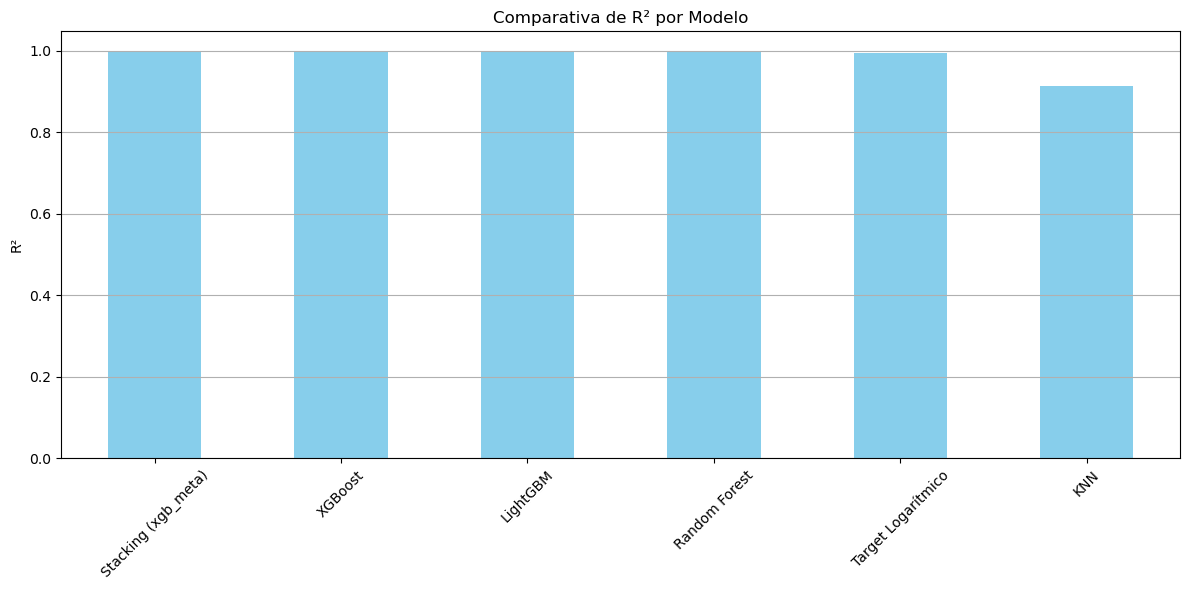

In [78]:
# Mostrar tabla comparativa
print("Comparación de modelos:")
print(results_df)

# Visualizar comparativa de R²
plt.figure(figsize=(12, 6))
results_df['R²'].plot(kind='bar', color='skyblue')
plt.title('Comparativa de R² por Modelo')
plt.ylabel('R²')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [79]:
# 19. CONCLUSIONES Y OBSERVACIONES FINALES
print("\n" + "="*50)
print("CONCLUSIONES Y OBSERVACIONES FINALES")
print("="*50)

best_model_name = results_df.index[0]
best_r2 = results_df.iloc[0]['R²']
best_rmse = results_df.iloc[0]['RMSE']

print(f"El mejor modelo es: {best_model_name} con un R² de {best_r2:.4f} y RMSE de {best_rmse:.2f} €")


CONCLUSIONES Y OBSERVACIONES FINALES
El mejor modelo es: Stacking (xgb_meta) con un R² de 0.9980 y RMSE de 400.24 €


In [80]:
import joblib 

In [ ]:
#joblib.dump(stacking, 'modelo_correcto.joblib')

['modelo_correcto.joblib']

In [ ]:
# Verificar tamaño
#tamano_archivo_mb = os.path.getsize('modelo_correcto.joblib') / (1024 * 1024)
#print(f"Tamaño con joblib: {tamano_archivo_mb:.2f} MB")

Tamaño con joblib: 54.93 MB


In [86]:
# Create a complete pipeline with preprocessing and model
from sklearn.pipeline import Pipeline

In [87]:
# Create the full pipeline
full_pipeline = Pipeline([
    ('preprocessor', tree_preprocessor),  # Your existing preprocessor
    ('model', stacking)  # Your stacking model that you previously saved
])

In [88]:
# Fit the pipeline on the original data (not preprocessed)
full_pipeline.fit(X_train_clean, y_train_clean)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['year', 'kms', 'power',
                                                   'dealer_zip_code',
                                                   'vehicle_age',
                                                   'price_per_power',
                                                   'price_per_year',
                                                   'power_per_kms',
                                                   'make_popularity',
                                                   'model_popularity',
                                                   'big_city_dealer',
                                                   'power_to_age',
                                                   'kms_per_year', 'log_kms',
                                                   'log_power',
                                                   'log_vehicle_age']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unkno...
                                                                grow_policy=None,
                                                                importance_type=None,
                                                                interaction_constraints=None,
                                                                learning_rate=0.05,
                                                                max_bin=None,
                                                                max_cat_threshold=None,
                                                                max_cat_to_onehot=None,
                                                                max_delta_step=None,
                                                                max_depth=3,
                                                                max_leaves=None,
                                                                min_child_weight=None,
                                                                missing=nan,
                                                                monotone_constraints=None,
                                                                multi_strategy=None,
                                                                n_estimators=100,
                                                                n_jobs=None,
                                                                num_parallel_tree=None,
                                                                random_state=42, ...),
                                   n_jobs=-1))])

In [89]:
# Evaluate on test data
y_pred_pipeline = full_pipeline.predict(X_test_clean)

r2_pipeline = r2_score(y_test_clean, y_pred_pipeline)
rmse_pipeline = np.sqrt(mean_squared_error(y_test_clean, y_pred_pipeline))
mae_pipeline = mean_absolute_error(y_test_clean, y_pred_pipeline)

print(f"Pipeline Performance:")
print(f"R²: {r2_pipeline:.4f}")
print(f"RMSE: {rmse_pipeline:.2f}")
print(f"MAE: {mae_pipeline:.2f}")


Pipeline Performance:
R²: 0.9980
RMSE: 400.24
MAE: 218.18


In [ ]:
# Compare with original stacking model
# (You should have already calculated these metrics for your stacking model)
y_pred_stack = stacking.predict(tree_preprocessor.transform(X_test_clean))
r2_stack = r2_score(y_test_clean, y_pred_stack)
rmse_stack = np.sqrt(mean_squared_error(y_test_clean, y_pred_stack))

print(f"\nComparison:")
print(f"Original Stacking - R²: {r2_stack:.4f}, RMSE: {rmse_stack:.2f}")
print(f"Full Pipeline - R²: {r2_pipeline:.4f}, RMSE: {rmse_pipeline:.2f}")



Comparison:
Original Stacking - R²: 0.9980, RMSE: 400.24
Full Pipeline - R²: 0.9980, RMSE: 400.24

Pipeline performance matches original model. Saving pipeline...
Pipeline saved successfully!


In [91]:
joblib.dump(full_pipeline, 'modelo_correcto.joblib')

['modelo_correcto.joblib']